In [1]:
# Install necessary libraries
!pip install ultralytics
!pip install plotly
!pip install opencv-python-headless

import os
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml
import shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
!pip install -q kaggle


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sajanm10","key":"fa238e79bf9542d960b069bcbc7dc97c"}'}

In [4]:
#create a kaggle folder
!mkdir ~/.kaggle
#copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes


In [7]:
# Paths to data directories
train_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train"
val_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val"


In [1]:
from pathlib import Path

# Paths to data directories
train_path = Path("/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train")
val_path = Path("/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val")

# Check if directories exist
if train_path.exists() and train_path.is_dir():
    print(f"Training directory exists: {train_path}")
    print("Contents of the training directory:")
    print([p.name for p in train_path.iterdir()])
else:
    print(f"Training directory does not exist: {train_path}")

if val_path.exists() and val_path.is_dir():
    print(f"Validation directory exists: {val_path}")
    print("Contents of the validation directory:")
    print([p.name for p in val_path.iterdir()])
else:
    print(f"Validation directory does not exist: {val_path}")


Training directory exists: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train
Contents of the training directory:
['Pituitary', 'No Tumor', 'Meningioma', 'Glioma']
Validation directory exists: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val
Contents of the validation directory:
['Pituitary', 'No Tumor', 'Meningioma', 'Glioma']


In [3]:
# Classes
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

In [8]:
# Function to load images and labels
def load_data(data_path):
    images = []
    labels = []
    for class_label in classes:
        class_path = os.path.join(data_path, class_label, 'images')
        label_path = os.path.join(data_path, class_label, 'labels')
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_file = img_file.replace('.jpg', '.txt')
            label_file_path = os.path.join(label_path, label_file)
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip().split()
                    if len(label_data) > 0:
                        images.append(img)
                        labels.append(label_data)
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    return images, labels

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)
# Split the validation set: 50% for validation, 50% for test
val_images, test_images, val_labels, test_labels = train_test_split(
    val_images, val_labels, test_size=0.5, random_state=42)

Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/labels/gg (342).txt is empty, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(61).txt not found, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(55).txt not found, skipping this image.


In [9]:
# EDA - Visualize class distribution
train_counts = [len(os.listdir(os.path.join(train_path, cls, 'images'))) for cls in classes]
val_counts = [len(os.listdir(os.path.join(val_path, cls, 'images'))) for cls in classes]
eda_df = pd.DataFrame({'Class': classes, 'Train': train_counts, 'Validation': val_counts})

fig = go.Figure(data=[
    go.Bar(name='Train', x=eda_df['Class'], y=eda_df['Train']),
    go.Bar(name='Validation', x=eda_df['Class'], y=eda_df['Validation'])
])
fig.update_layout(barmode='group', title='Class Distribution in Training and Validation Sets')
fig.show()

In [12]:
import os
import shutil
from ultralytics import YOLO

# Step 1: Define paths
source_dir = '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes'
train_source = os.path.join(source_dir, 'Train')
val_source = os.path.join(source_dir, 'Val')
dataset_dir = '/kaggle/working/brain_tumor_dataset'

# Step 2: Create YOLOv8 structure
for split in ['train', 'val']:
    os.makedirs(f'{dataset_dir}/images/{split}', exist_ok=True)
    os.makedirs(f'{dataset_dir}/labels/{split}', exist_ok=True)

# Step 3: Move images and labels to YOLO format
def prepare_data(source_split_dir, split):
    for class_dir_name in os.listdir(source_split_dir):
        # Construct the path to the class directory
        class_path = os.path.join(source_split_dir, class_dir_name)

        # Check if it's actually a directory (skip files or hidden items)
        if os.path.isdir(class_path):
            # Construct paths to the 'images' and 'labels' subdirectories
            img_source_dir = os.path.join(class_path, 'images')
            lbl_source_dir = os.path.join(class_path, 'labels')

            # Check if 'images' directory exists
            if os.path.exists(img_source_dir) and os.path.isdir(img_source_dir):
                # Iterate through image files in the 'images' subdirectory
                for file in os.listdir(img_source_dir):
                    file_path = os.path.join(img_source_dir, file)
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        # Copy image file to the destination
                        shutil.copy(file_path, f'{dataset_dir}/images/{split}/{file}')
            else:
                print(f"Warning: Images directory not found for class '{class_dir_name}' in {source_split_dir}")

            # Check if 'labels' directory exists
            if os.path.exists(lbl_source_dir) and os.path.isdir(lbl_source_dir):
                 # Iterate through label files in the 'labels' subdirectory
                for file in os.listdir(lbl_source_dir):
                    file_path = os.path.join(lbl_source_dir, file)
                    if file.lower().endswith('.txt'):
                        # Copy label file to the destination
                        shutil.copy(file_path, f'{dataset_dir}/labels/{split}/{file}')
            else:
                print(f"Warning: Labels directory not found for class '{class_dir_name}' in {source_split_dir}")


prepare_data(train_source, 'train')
prepare_data(val_source, 'val')

# Step 4: Write data.yaml
data_yaml = f"""
path: {dataset_dir}
train: images/train
val: images/val
nc: 4
names: ['Pituitary', 'No Tumor', 'Meningioma', 'Glioma']
"""
with open(f'{dataset_dir}/data.yaml', 'w') as f:
    f.write(data_yaml)

# Step 5: Train YOLOv8 model
model = YOLO('yolov8n.pt')  # You can use yolov8s.pt for a larger model
model.train(data=f'{dataset_dir}/data.yaml', epochs=20, imgsz=640)

# Step 6: Inference example on validation images
val_images_dir = f'{dataset_dir}/images/val'
results = model(val_images_dir, save=True, conf=0.4)  # Adjust conf threshold as needed


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/brain_tumor_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /kaggle/working/brain_tumor_dataset/labels/train.cache... 4737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 488.2±383.2 MB/s, size: 28.4 KB)


val: Scanning /kaggle/working/brain_tumor_dataset/labels/val.cache... 510 images, 3 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.4G       1.02      2.382      1.207          3        640: 100%|██████████| 297/297 [01:22<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]

                   all        512        554      0.714      0.704      0.766      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.8G      1.056       1.41      1.214          1        640: 100%|██████████| 297/297 [01:17<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]

                   all        512        554      0.786      0.689       0.78       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.8G      1.046      1.131      1.207          2        640: 100%|██████████| 297/297 [01:18<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.18it/s]

                   all        512        554      0.759      0.722      0.756      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.81G      1.017     0.9789      1.195          3        640: 100%|██████████| 297/297 [01:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]

                   all        512        554      0.868      0.817      0.891      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.81G     0.9853     0.8965      1.176          2        640: 100%|██████████| 297/297 [01:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]

                   all        512        554      0.826      0.854      0.908       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.81G     0.9404     0.8269      1.157          1        640: 100%|██████████| 297/297 [01:21<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]

                   all        512        554      0.704      0.785      0.797      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.81G     0.9259      0.787      1.139          2        640: 100%|██████████| 297/297 [01:22<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]

                   all        512        554      0.897      0.838      0.914      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.81G     0.9253     0.7586       1.14          1        640: 100%|██████████| 297/297 [01:19<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        512        554      0.889      0.866      0.922       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.81G     0.9014     0.7201      1.128          1        640: 100%|██████████| 297/297 [01:17<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        512        554      0.898      0.901      0.937      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.81G     0.8736      0.678      1.109          2        640: 100%|██████████| 297/297 [01:20<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]

                   all        512        554      0.916      0.871      0.935       0.72


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.81G       0.83     0.6157      1.084          2        640: 100%|██████████| 297/297 [01:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]

                   all        512        554      0.929      0.878      0.945      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.81G     0.8033     0.5762      1.067          2        640: 100%|██████████| 297/297 [01:12<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]

                   all        512        554      0.928      0.899       0.95      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.81G      0.789     0.5506      1.058          1        640: 100%|██████████| 297/297 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]

                   all        512        554      0.893      0.917      0.949      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.83G     0.7674     0.5267      1.051          1        640: 100%|██████████| 297/297 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.37it/s]

                   all        512        554      0.915      0.924      0.958      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.84G      0.756     0.4985      1.034          1        640: 100%|██████████| 297/297 [01:13<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]

                   all        512        554      0.934      0.936       0.96      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.85G     0.7345     0.4831      1.027          1        640: 100%|██████████| 297/297 [01:14<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.10it/s]

                   all        512        554      0.916      0.945      0.959      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.85G     0.7216     0.4518      1.015          1        640: 100%|██████████| 297/297 [01:14<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        512        554      0.949      0.926      0.961      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.85G     0.7139     0.4409      1.006          1        640: 100%|██████████| 297/297 [01:13<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        512        554      0.948      0.925       0.97      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.85G     0.6909     0.4207     0.9964          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

                   all        512        554      0.925      0.954      0.968       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.85G     0.6894     0.4085     0.9951          1        640: 100%|██████████| 297/297 [01:13<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]

                   all        512        554      0.953      0.934      0.968      0.797



20 epochs completed in 0.452 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]


                   all        512        554      0.953      0.934      0.968      0.797
             Pituitary        135        153      0.937      0.873      0.938      0.762
              No Tumor        140        142      0.979      0.988      0.992      0.833
            Meningioma         98         98      0.977          1      0.983      0.836
                Glioma        154        161       0.92      0.876      0.959      0.755
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train4

image 1/512 /kaggle/working/brain_tumor_dataset/images/val/Te-pi_0018.jpg: 640x640 1 Glioma, 10.8ms
image 2/512 /kaggle/working/brain_tumor_dataset/images/val/Te-pi_0021.jpg: 640x640 1 Glioma, 8.9ms
image 3/512 /kaggle/working/brain_tumor_dataset/images/val/Te-pi_0025.jpg: 640x640 1 Glioma, 8.5ms
image 4/512 /kaggle/working/brain_tumor_dataset/images/val/Te-pi_0036.jpg: 640x640 1 Glioma, 8.0ms
image 5/512 /kaggle/working/brain_tumor

TypeError: unsupported operand type(s) for /: 'str' and 'str'

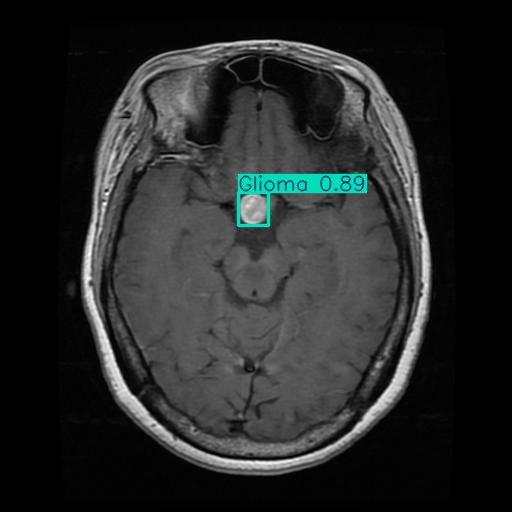

In [15]:
# Display a sample prediction (optional)
from IPython.display import Image, display
import os # Ensure os is imported if not already

for r in results:
    # Use os.path.join to correctly combine the directory and filename
    display(Image(filename=os.path.join(r.save_dir, os.path.basename(r.path))))
    break  # Show just one example


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/gg (409).jpg: 640x640 3 Pituitarys, 1 Glioma, 9.4ms
Speed: 3.9ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


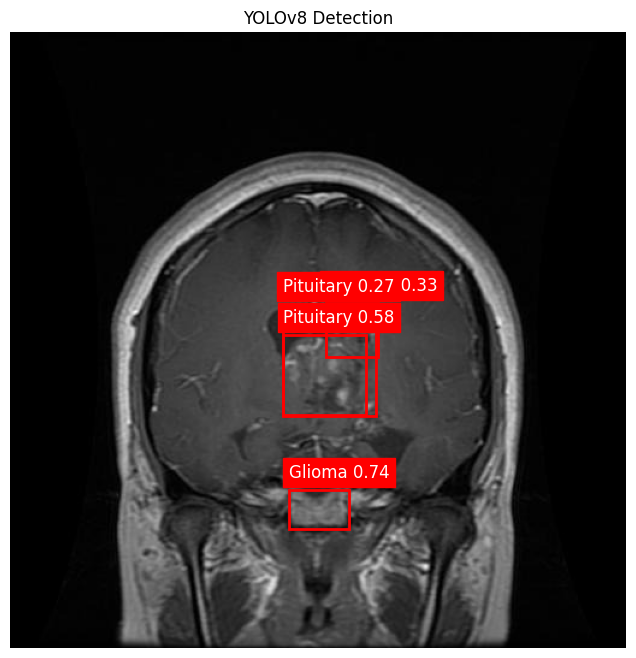


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/gg (47).jpg: 640x640 1 Pituitary, 10.6ms
Speed: 4.7ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


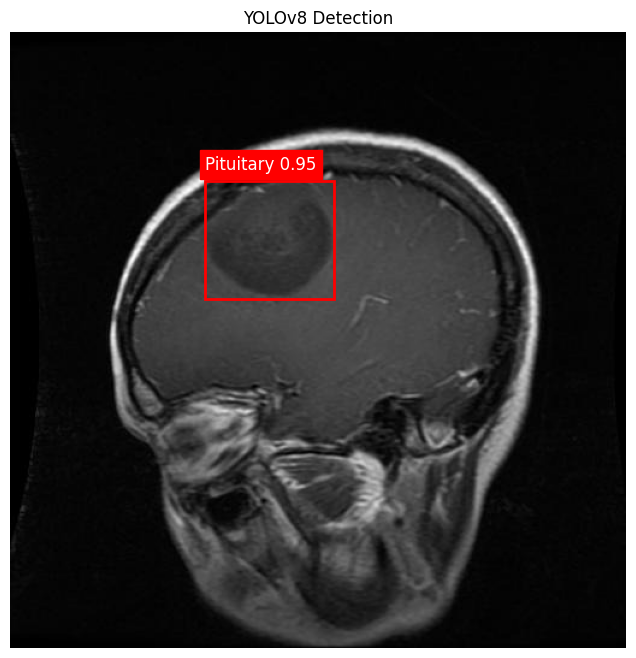


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/image (7).jpg: 640x576 1 Meningioma, 10.7ms
Speed: 3.8ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


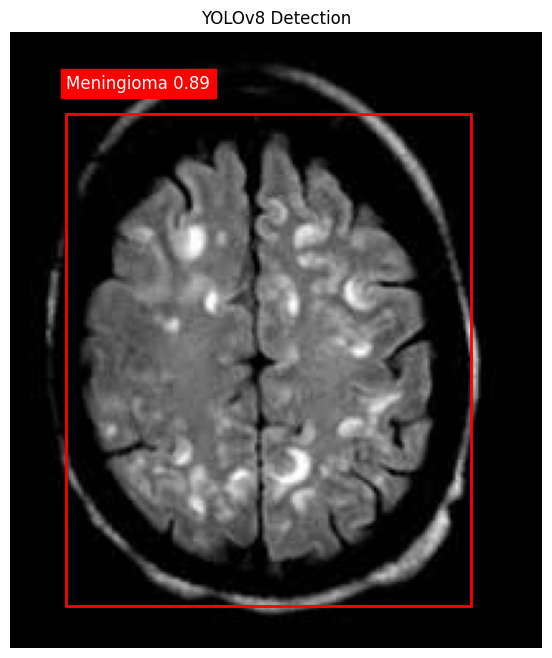


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/Tr-pi_1448.jpg: 640x640 1 Glioma, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


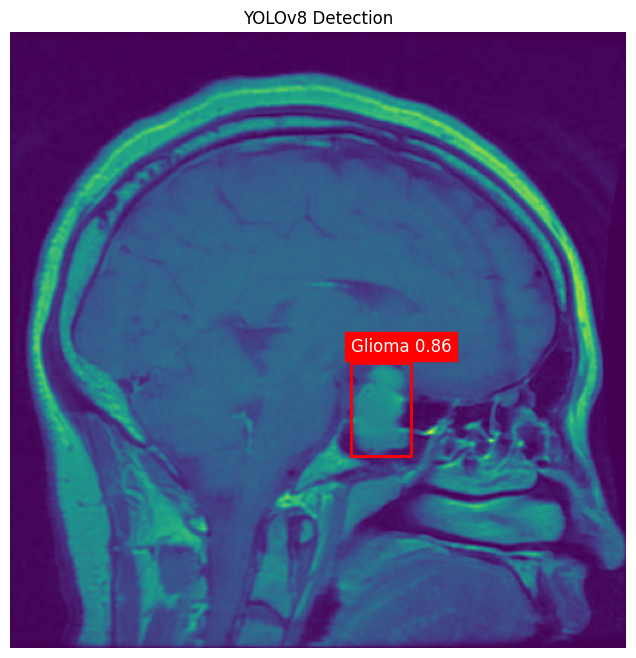


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/m (65).jpg: 640x640 1 No Tumor, 8.4ms
Speed: 8.7ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


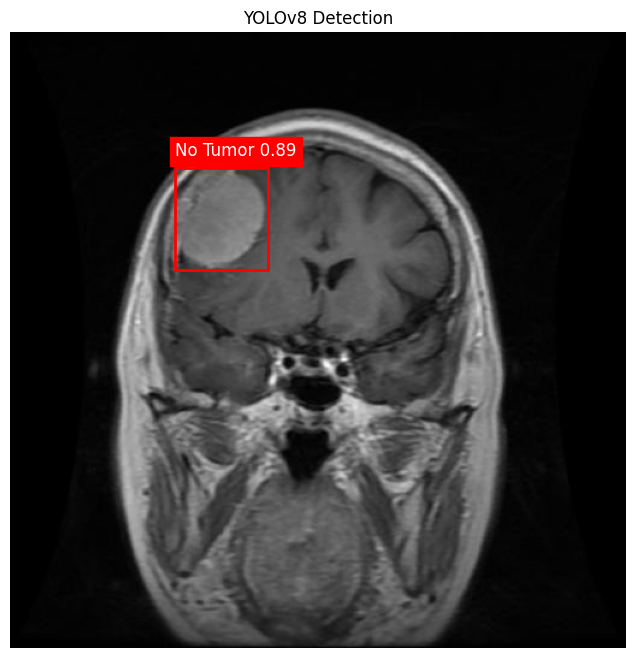


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/Tr-me_0057.jpg: 640x640 1 No Tumor, 10.0ms
Speed: 6.9ms preprocess, 10.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


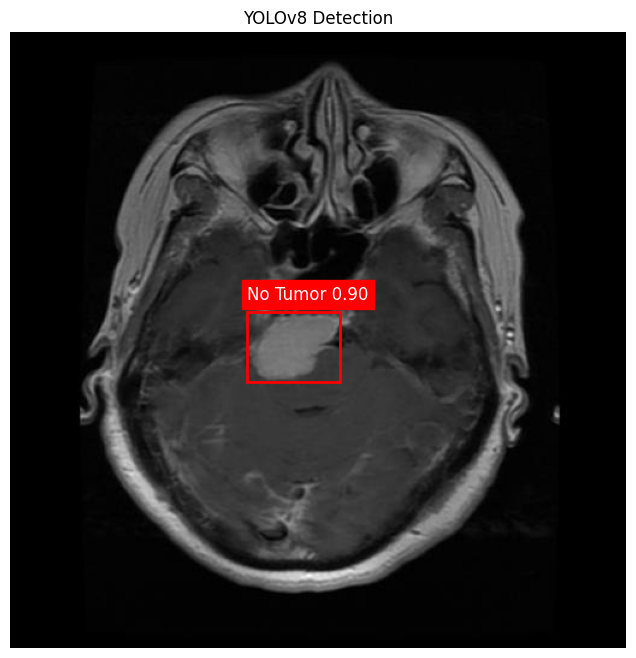


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/Tr-pi_0907.jpg: 640x640 1 Glioma, 10.2ms
Speed: 5.9ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


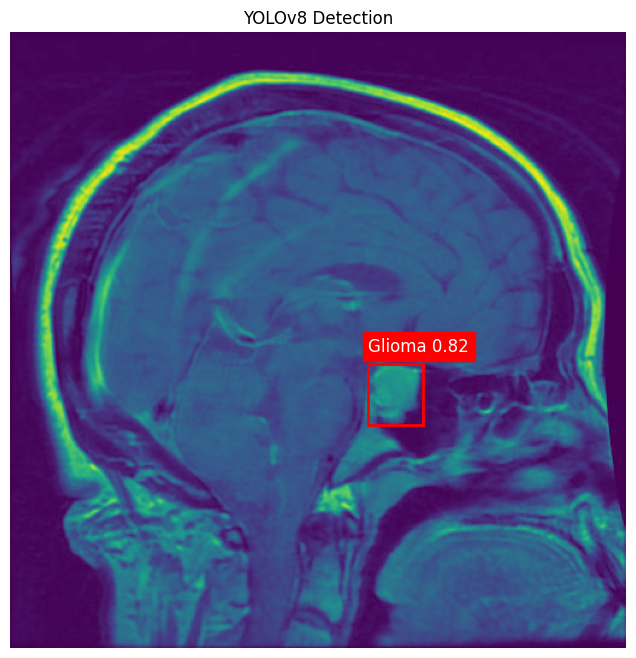


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/Tr-pi_0247.jpg: 640x640 1 Glioma, 9.2ms
Speed: 4.3ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


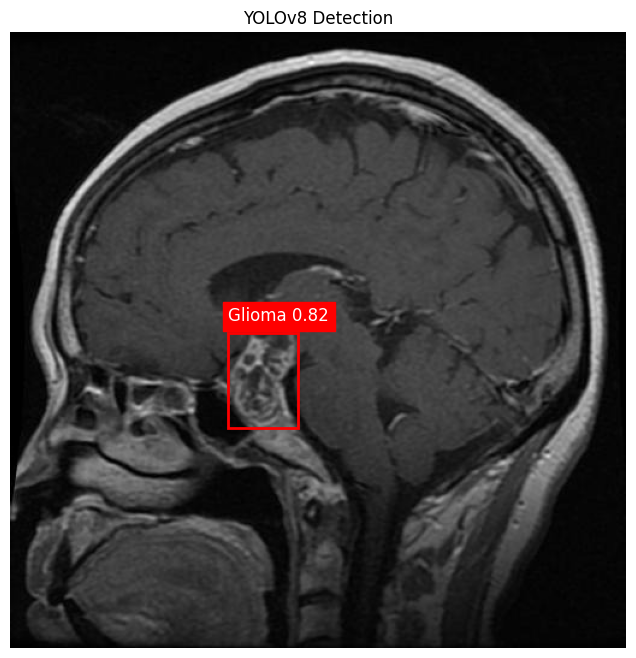


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/Tr-gl_0640.jpg: 640x640 1 Pituitary, 1 Glioma, 11.1ms
Speed: 4.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


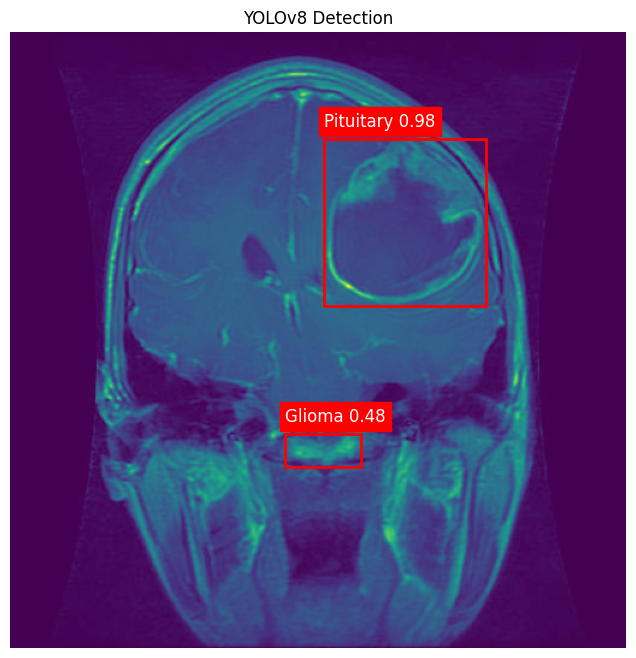


image 1/1 /kaggle/working/brain_tumor_dataset/images/val/Tr-pi_0183.jpg: 640x640 1 Glioma, 12.5ms
Speed: 4.2ms preprocess, 12.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


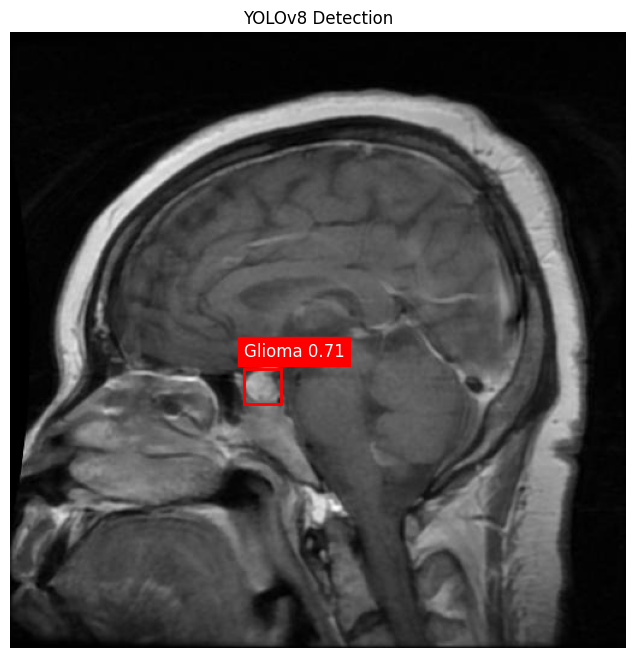

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os

# Define class names (same as in data.yaml)
classes = ['Pituitary', 'No Tumor', 'Meningioma', 'Glioma']

# Function to display detection results with highlighted parts
def display_samples(images_dir, yolo_model, num_samples=10):
    images = [os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    images = images[:num_samples]  # Limit to first N images

    for img_path in images:
        img = Image.open(img_path)
        img_array = np.array(img)

        results = yolo_model(img_path)[0]  # Run inference on a single image
        plt.figure(figsize=(8, 8))
        plt.imshow(img_array)
        ax = plt.gca()

        # Draw bounding boxes and labels
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1 - 10, f"{classes[cls]} {conf:.2f}", color='white', fontsize=12, backgroundcolor='red')

        plt.title('YOLOv8 Detection')
        plt.axis('off')
        plt.show()

# Usage example (after model training and loading)
val_images_dir = f'{dataset_dir}/images/val'
display_samples(val_images_dir, model)
